In [1]:
## Exploratory Data Analysis

In [2]:
# import preliminaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

weather = pd.read_csv('madweather.csv', parse_dates = ['DATE'], sep=',', infer_datetime_format = True)
weather.sort_values("DATE", axis = 0, ascending = True,inplace = True) 

# check shape
print(weather.shape)

#select datetime and temperature columns bc multivariate is too difficult
dprcp = weather[['DATE', 'PRCP']]
#fill missing 
dprcp = dprcp.fillna(method="ffill")
# set index
dprcp.set_index('DATE',inplace=True)
dprcp.head(10)

(1452, 3)


,PRCP
DATE,
1900-01-01,0.69
1900-02-01,1.26
1900-03-01,1.33
1900-04-01,1.31
1900-05-01,1.87
1900-06-01,3.20
1900-07-01,6.91
1900-08-01,2.71
1900-09-01,2.89


In [3]:
dprcp.describe()

,PRCP
count,1452.000000
mean,2.713258
std,1.943063
min,0.040000
25%,1.310000
50%,2.270000
75%,3.572500
max,14.620000


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


[Text(0.5, 1.0, 'Monthly Precipitation in Madison, WI from 1900 to 2020'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Precipitation (in)')]

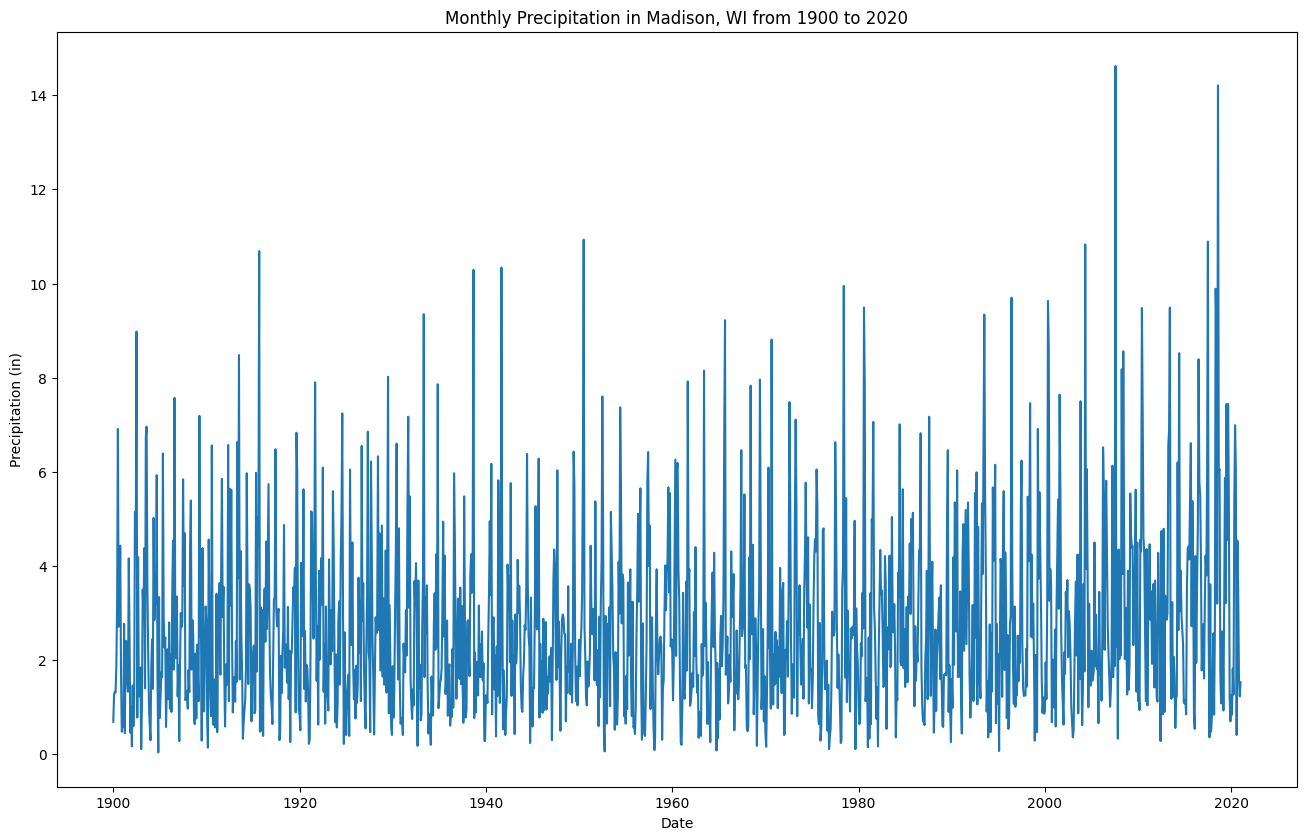

In [4]:
# plot
# choosing prcp over other variables in orig dataset bc has least missing data
%pylab
%matplotlib inline
plt.figure(figsize(16,10), dpi=100)
plt.plot(dprcp.index, dprcp.PRCP, color = 'tab:blue')
plt.gca().set(title="Monthly Precipitation in Madison, WI from 1900 to 2020", xlabel = 'Date', ylabel="Precipitation (in)")

[Text(0.5, 1.0, 'Moving Average Time Series Plot of Size 12'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Precipitation (Millimeters)')]

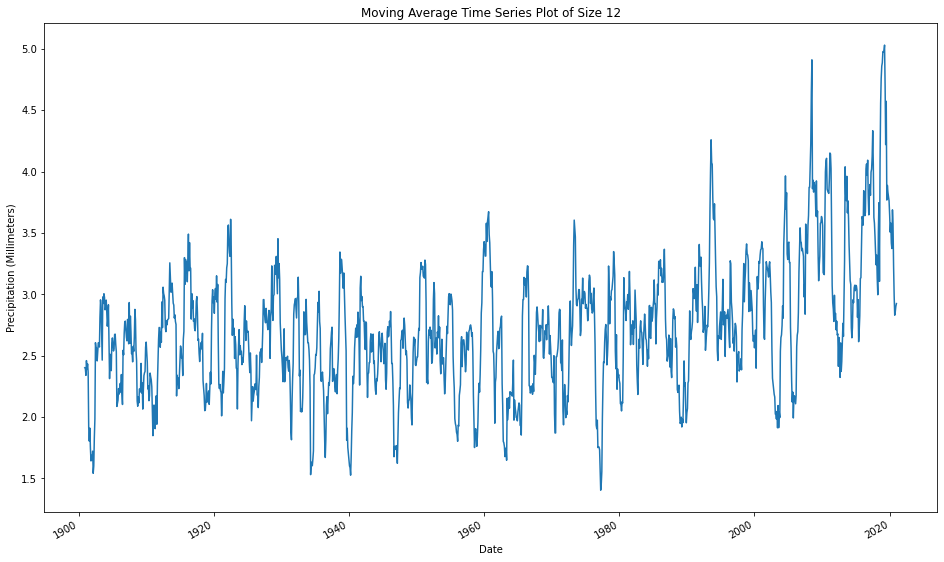

In [5]:
prcp_mean = dprcp.PRCP.rolling(window=12).mean()
prcp_mean.plot().set(title = 'Moving Average Time Series Plot of Size 12', xlabel = 'Date', ylabel = 'Precipitation (Millimeters)')


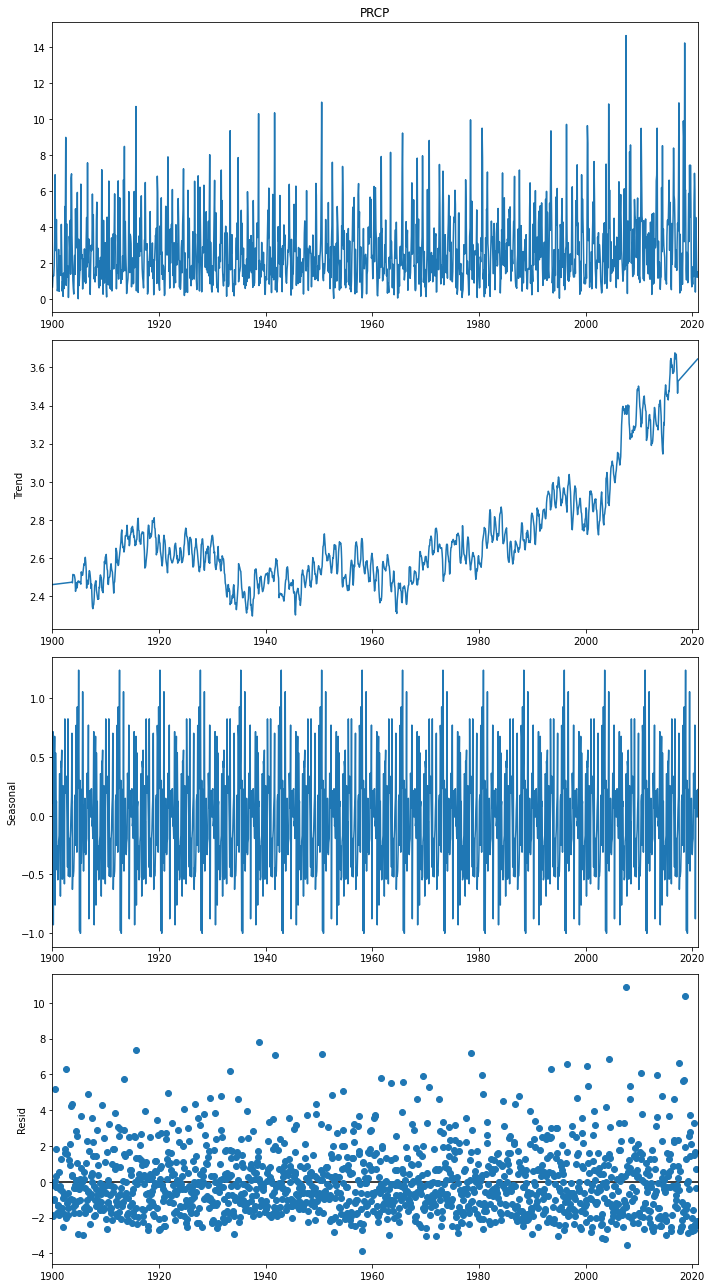

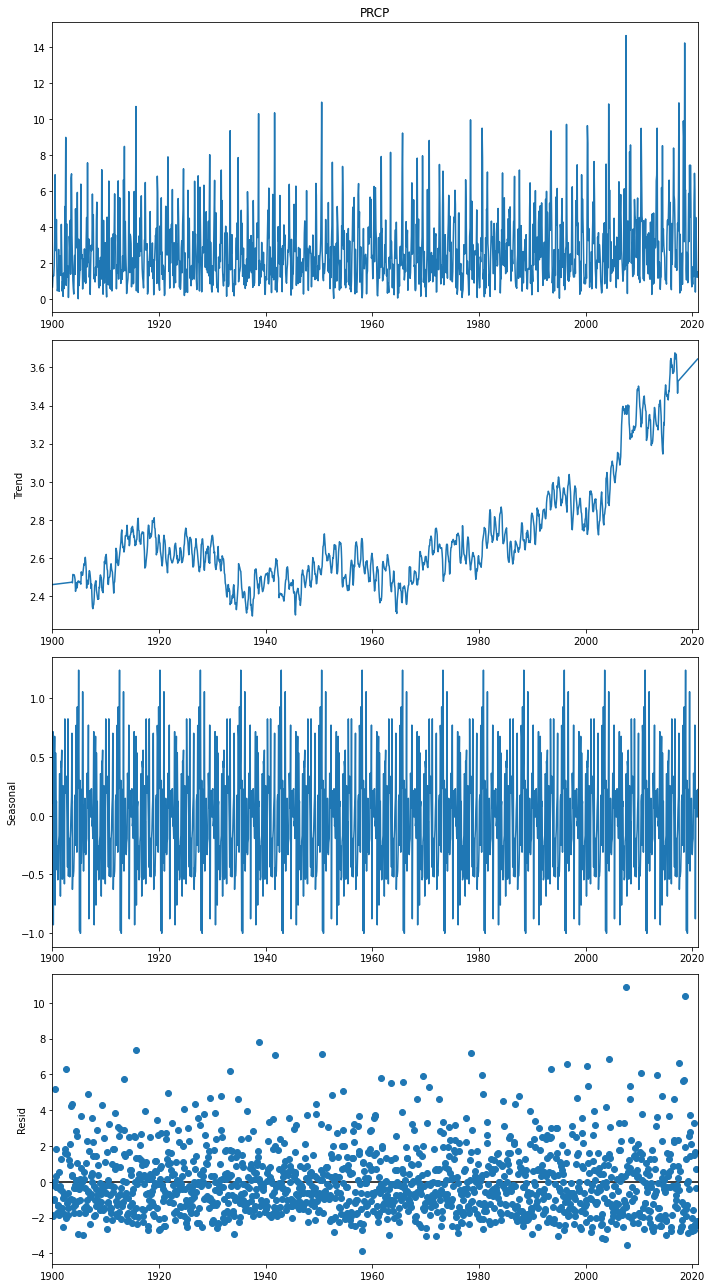

In [6]:
# decompose
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(dprcp.PRCP[:], model = 'additive', extrapolate_trend = 'freq', freq = 91)

# plot
plt.rcParams.update({'figure.figsize': (10,18)})
result_add.plot()
# reasonably stable

In [7]:
## baseline model

In [8]:
# 1-step prediction
# shift current month temp to next month
predicted = (dprcp['PRCP'].to_frame().shift(1).rename(columns = {'PRCP': 'PRCP_pred'}))
actual = (dprcp['PRCP'].to_frame().rename(columns = {'PRCP': 'PRCP_actual'}))

# concatenate
one_step_df = pd.concat([actual, predicted], axis=1)

one_step_df = one_step_df[1:]
one_step_df.tail()


,PRCP_actual,PRCP_pred
DATE,,
2020-09-01,4.54,0.41
2020-10-01,3.49,4.54
2020-11-01,1.57,3.49
2020-12-01,1.23,1.57
2021-01-01,1.53,1.23


In [9]:
# check RMSE to validate how well model is performing
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

prcp_pred_err = sqrt(MSE(one_step_df.PRCP_actual, one_step_df.PRCP_pred))
print('RMSE:',prcp_pred_err)
mape = np.mean(np.abs(one_step_df.PRCP_pred - one_step_df.PRCP_actual)/np.abs(one_step_df.PRCP_actual))
print('MAPE of forecasts:', mape)

RMSE: 2.358817146831161
MAPE of forecasts: 1.1110237085488501


In [10]:
# small enough that we can use baseline model to predict upcoming month's precipitation withh arror of 2.6 in. 
# weather predictions are often wrong so we accept this

In [11]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]


In [12]:
# SARIMA model
# grid search to explore combos of params, fit new SARIMA to each
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.PRCP_actual,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            
            results = mod.fit()
            
            print(('SARIMA{}x{}12 - AIC:{}').format(param,param_seasonal,results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7613.326459686713
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6924.653324627263
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6456.024306276418
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5556.702648920587
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6285.289133750729
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5598.673840829164
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6045.198915534727
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:5562.728830487879
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7019.959947400457
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6631.9710782721595
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6452.94536668474
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5552.361580457924
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6263.834323895764
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5595.357520665935
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6046.115496883847
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5557.929122846224
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6602.97180127749
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:6541.672469

In [13]:
 # SARIMA(0, 1, 1)x(0, 1, 1, 12)12  yields lowest AIC values of 5547. We consider this the optimal option out of all models considered.

In [14]:
# fit model

In [15]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(one_step_df.PRCP_actual,
                               order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_inveribility = False)

results = mod.fit()

In [16]:
# model diagnostics

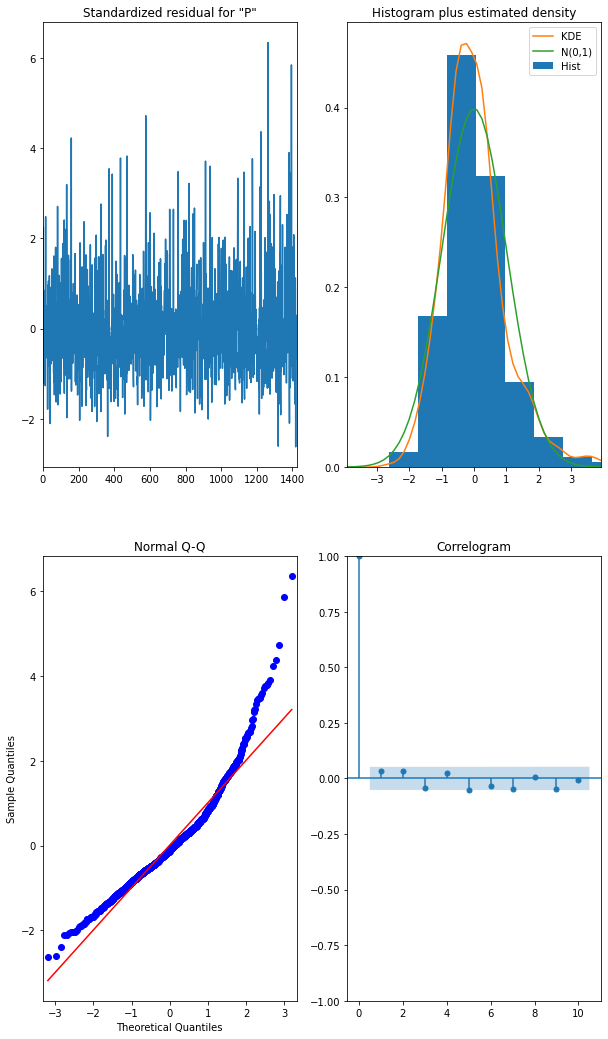

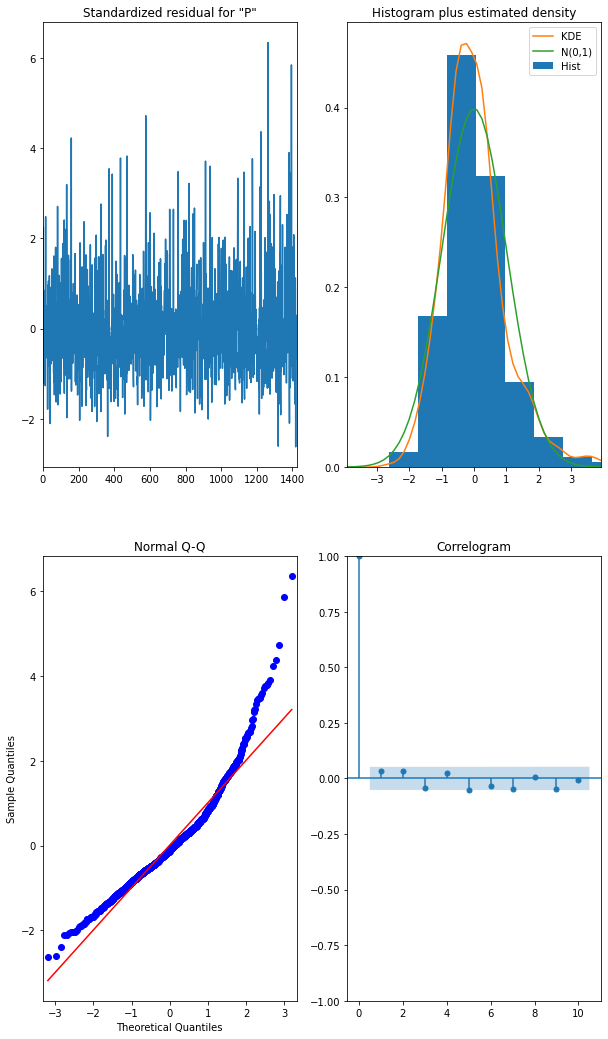

In [17]:
results.plot_diagnostics()
# We can see in top right that orange KDE line follows loosely with N(0,1) line. This is okay indicator of normally distributed residuals. The qq-plot shows a linear trend with some deviations at the head and tail. The residuals over time in the top left do not show obvious seasonality. 
# satisfactory fit


In [18]:
#let's validate!
pred = results.get_prediction(start = pd.to_datetime('1996-01-01'), dynamic = False)
pred_ci = pred.conf_int()

<Figure size 1000x1600 with 0 Axes>

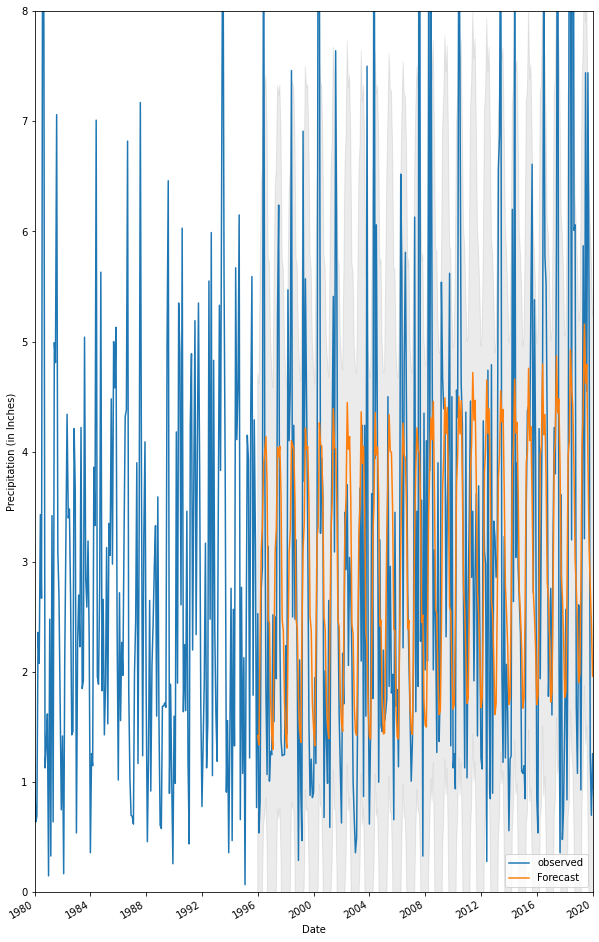

<Figure size 1000x1600 with 0 Axes>

In [19]:
# non-dynamic forecast
ax = one_step_df.PRCP_actual['1900-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=.08)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,8])
plt.xlim(['1980-01-01','2020-01-01'])
plt.legend()
plt.figure(figsize(10,16
                  ), dpi=100)

In [20]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.PRCP_actual['1996-01-01':]
print(y_forecasted.shape)
print(y_truth.shape)
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('MSE of forecasts:',(round(mse,3)))
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print('MAPE of forecasts:', mape)

(301,)
(301,)
MSE of forecasts: 2.018
MAPE of forecasts: 0.7558359955111409


In [21]:
# dynamic forecast
pred_dynamic = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

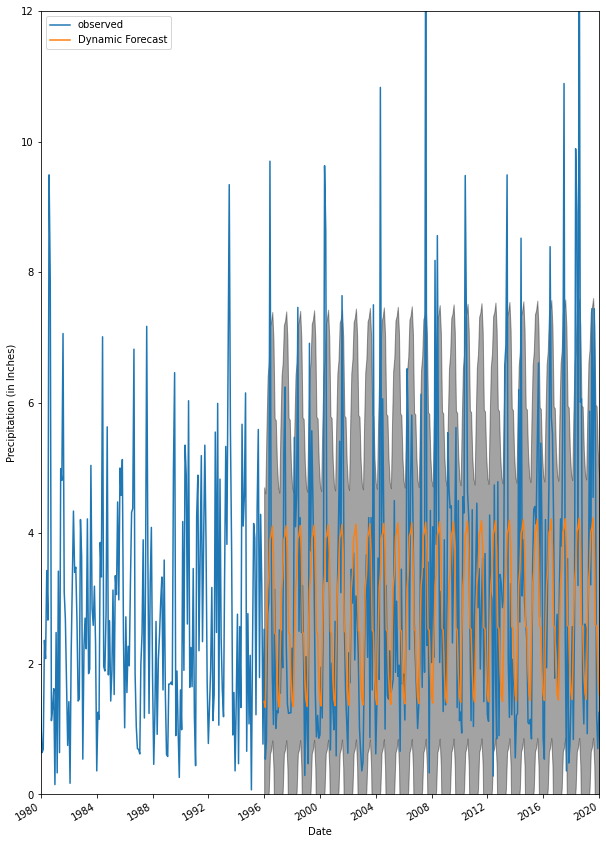

In [22]:
ax = one_step_df.PRCP_actual['1900':].plot(label='observed')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast')

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:,0],
               pred_dynamic_ci.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,12])
plt.legend()

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:,0],
               pred_dynamic_ci.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,12])
plt.xlim(['1980-01-01','2020-01-01'])
plt.legend()

In [23]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.PRCP_actual['1996-01-01':]
print(y_forecasted.shape)
print(y_truth.shape)
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('MSE of forecasts:',(round(mse,3)))
mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
print(mape)
# mse is higher, which makes sense bc relying on less historical data from time series

(301,)
(301,)
MSE of forecasts: 2.059
0.7172401794012571


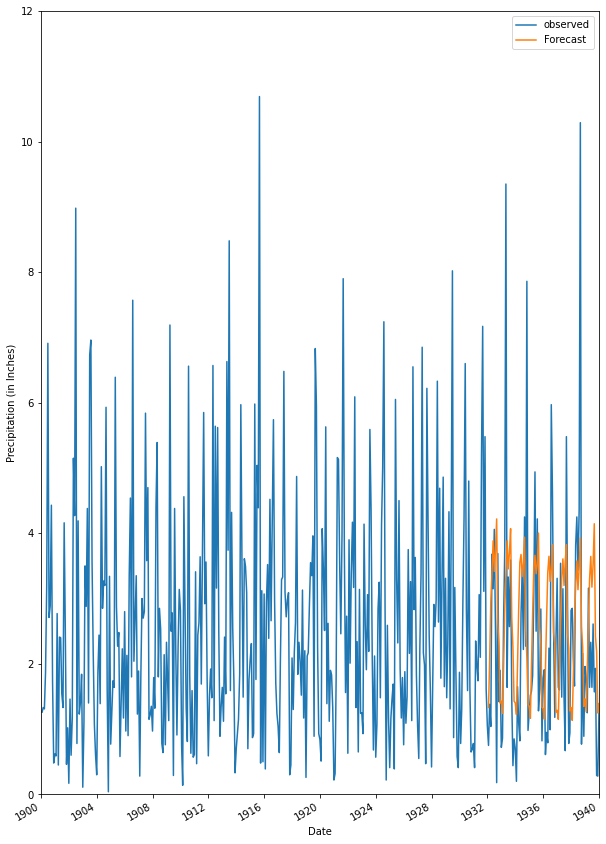

In [24]:
# chunk 1
pred1 = results.get_prediction(start=pd.to_datetime('1932-02-01'),end = pd.to_datetime('1940-01-01'), dynamic = False)
pred1_ci = pred.conf_int()

ax = one_step_df.PRCP_actual['1900-02-01':'1940-01-01'].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred1_ci.index,
               pred1_ci.iloc[:,0],
               pred1_ci.iloc[:,1], color='k', alpha=.08)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,12])
plt.xlim(['1900-01-01','1940-01-01'])
plt.legend()



In [25]:
y1_forecasted = pred1.predicted_mean
y1_truth = one_step_df.PRCP_actual['1932-02-01':'1940-01-01']
print(y1_forecasted.shape)
print(y1_truth.shape)
mse = sqrt(MSE(y1_truth, y1_forecasted).mean())
print('MSE of forecasts:',(round(mse,3)))
mape = np.mean(np.abs(np.array(y1_forecasted) - np.array(y1_truth))/np.abs(np.array(y1_truth)))
print('MAPE of forecasts:', mape)

(96,)
(96,)
MSE of forecasts: 1.653
MAPE of forecasts: 1.0688401055712322


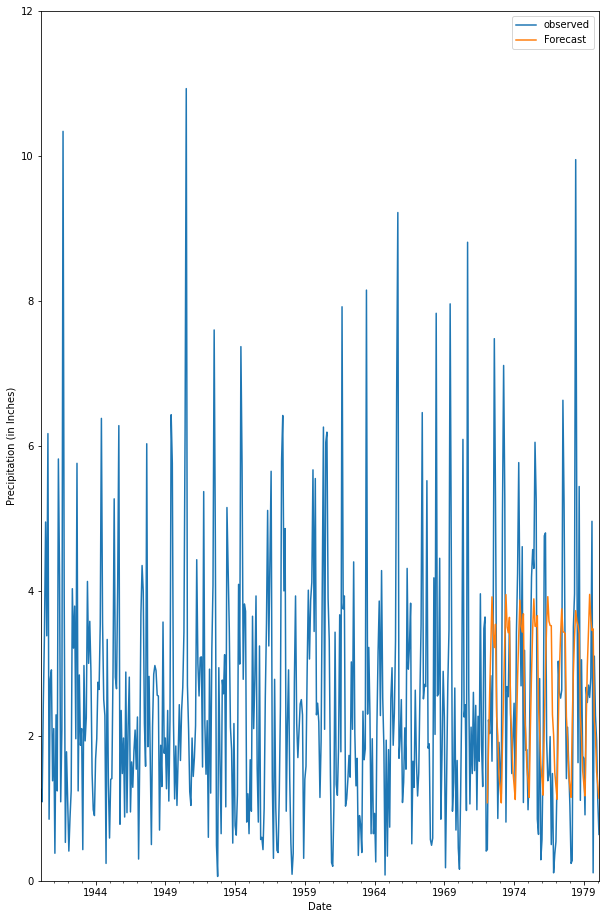

(97,)
(97,)
MSE of forecasts: 1.626
MAPE of forecasts: 1.2388424069620296


In [26]:
# chunk 2
pred2 = results.get_prediction(start=pd.to_datetime('1972-02-01'),end = pd.to_datetime('1980-02-01'), dynamic = False)
pred2_ci = pred.conf_int()

ax = one_step_df.PRCP_actual['1940-02-01':'1980-02-01'].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred2_ci.index,
               pred2_ci.iloc[:,0],
               pred2_ci.iloc[:,1], color='k', alpha=.08)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,12])
plt.xlim(['1940-02-01','1980-02-01'])
plt.legend()
plt.show()

y2_forecasted = pred2.predicted_mean
y2_truth = one_step_df.PRCP_actual['1972-02-01':'1980-02-01']
print(y2_forecasted.shape)
print(y2_truth.shape)
mse = sqrt(MSE(y2_truth, y2_forecasted).mean())
print('MSE of forecasts:',(round(mse,3)))
mape = np.mean(np.abs(y2_forecasted - y2_truth)/np.abs(y2_truth))
print('MAPE of forecasts:', mape)

(85,)
(85,)
MSE of forecasts: 2.288
MAPE of forecasts: 0.9485509285926969


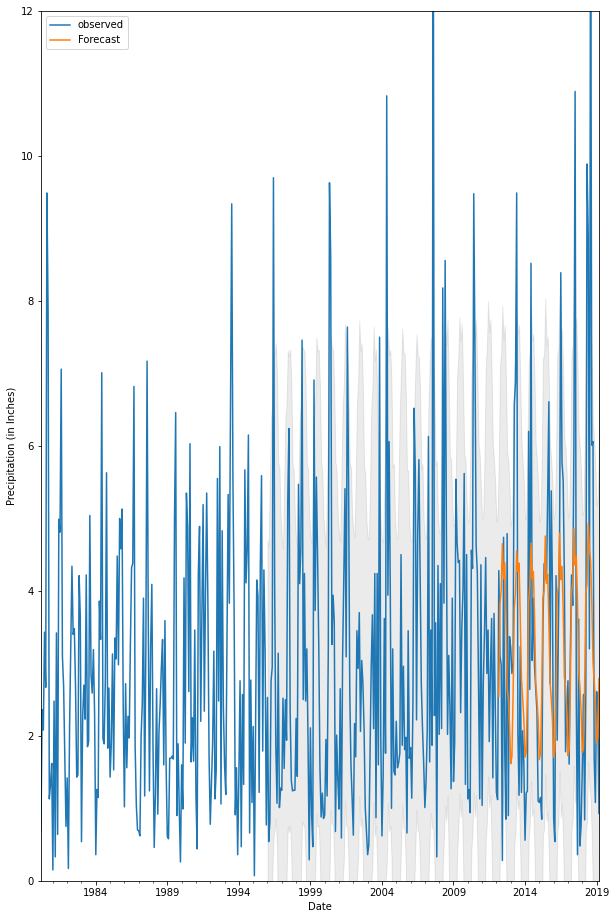

In [27]:
# chunk 3
pred3 = results.get_prediction(start=pd.to_datetime('2012-03-01'),end = pd.to_datetime('2019-03-01'), dynamic = False)
pred3_ci = pred.conf_int()

ax = one_step_df.PRCP_actual['1980-02-01':'2019-03-01'].plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred3_ci.index,
               pred3_ci.iloc[:,0],
               pred3_ci.iloc[:,1], color='k', alpha=.08)

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in Inches)')
plt.ylim([0,12])
plt.xlim(['1980-03-01','2019-03-01'])
plt.legend()

y3_forecasted = pred3.predicted_mean
y3_truth = one_step_df.PRCP_actual['2012-03-01':'2019-03-01']
print(y3_forecasted.shape)
print(y3_truth.shape)
mse = sqrt(MSE(y3_truth, y3_forecasted).mean())
print('MSE of forecasts:',(round(mse,3)))
mape = np.mean(np.abs(y3_forecasted - y3_truth)/np.abs(y3_truth))
print('MAPE of forecasts:', mape)